In [1]:
wiki_path = './灼眼的夏娜_wiki.txt'
novel_path='./灼眼的夏娜.txt'
output_dir='./output_shana/'
faiss_path=output_dir+'faiss_index'

include_novel=False
include_title=True
max_title_len=20
min_content_len=20
max_content_len=150
chunk_overlap=50

import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# faiss_cache_dir=output_dir+'faiss_cache'
# if not os.path.exists(faiss_cache_dir):
#     os.makedirs(faiss_cache_dir)

# 读取wiki txt，分块

successfully read novel text from  ./灼眼的夏娜.txt
successfully read wiki text from  ./灼眼的夏娜_wiki.txt


c:\Anaconda3\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


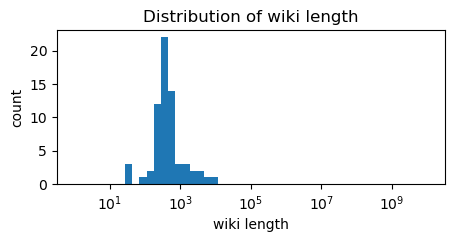

Number of wikis:  66


In [2]:
import re

with open(novel_path,'r',encoding='utf-8') as f:
    novel_text=f.read()
print('successfully read novel text from ', novel_path)

re_chapter_title=re.compile(r"^(.{1,8}章|.{1,8}篇|.{1,8}集|.{1,8}卷|后记|序)\s", flags=re.MULTILINE)
chapters = re.split(re_chapter_title, novel_text)[1:]
chapters = [chapters[i]+' '+chapters[i + 1] for i in range(0, len(chapters), 2) if len(chapters[i + 1]) > min_content_len]
chapter_titles=[chapter.split('\n')[0].strip()[:max_title_len] for chapter in chapters]
chapters=[chapter.split('\n',1)[1] for chapter in chapters]
    
with open(wiki_path,'r',encoding='utf-8') as f:
    wiki_text=f.read()
print('successfully read wiki text from ', wiki_path)

re_wiki_title=re.compile(r"^(【词条】)\s", flags=re.MULTILINE)
wikis=re.split(re_wiki_title,wiki_text)[1:]
wikis=[wikis[i]+' '+wikis[i+1] for i in range(0,len(wikis),2) if len(wikis[i+1])>min_content_len]
wiki_titles=[wiki.split('\n')[0].strip().replace('【词条】','')[:max_title_len] for wiki in wikis]
wikis=[wiki.split('\n',1)[1] for wiki in wikis]


import matplotlib.pyplot as plt
import numpy as np
if include_novel:
    plt.figure(figsize=(5, 2))
    plt.hist([len(chapter) for chapter in chapters], bins=np.logspace(0, 10, 50))
    plt.xscale('log');plt.xlabel('chapter length');plt.ylabel('count');plt.title('Distribution of chapter length');plt.show()
    print('Number of chapters: ', len(chapters))

plt.figure(figsize=(5, 2))
plt.hist([len(wiki) for wiki in wikis], bins=np.logspace(0, 10, 50))
plt.xscale('log');plt.xlabel('wiki length');plt.ylabel('count');plt.title('Distribution of wiki length');plt.show()
print('Number of wikis: ', len(wikis))


Number of documents:  557


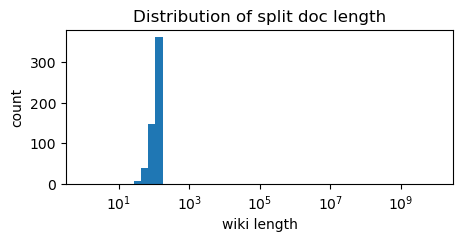

Number of docs:  557


In [3]:
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter=RecursiveCharacterTextSplitter(chunk_size=max_content_len,chunk_overlap=chunk_overlap)

documents=[]
documents+=[Document(page_content=wiki,metadata={'title':title,'type':'wiki'}) for wiki,title in zip(wikis,wiki_titles)]
if include_novel:
    documents+=[Document(page_content=chapter,metadata={'title':title,'type':'novel'}) for chapter,title in zip(chapters,chapter_titles)]
documents=text_splitter.split_documents(documents)
for doc in documents:
    if include_title:
        doc.page_content=doc.metadata['title']+'\n'+doc.page_content
    doc.page_content=doc.page_content.replace('\n',' ').strip()
documents=[doc for doc in documents if len(doc.page_content)>min_content_len]

print('Number of documents: ', len(documents))

import random
random.sample(documents,5)

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 2))
plt.hist([len(doc.page_content) for doc in documents], bins=np.logspace(0, 10, 50))
plt.xscale('log');plt.xlabel('wiki length');plt.ylabel('count');plt.title('Distribution of split doc length');plt.show()
print('Number of docs: ', len(documents))

# 建立FAISS索引

In [4]:
from langchain.embeddings import HuggingFaceEmbeddings
import sentence_transformers
from langchain.vectorstores import FAISS

embeddings = HuggingFaceEmbeddings(model_name=r'D:\ml\text2vec-large-chinese')
embeddings.client=sentence_transformers.SentenceTransformer(embeddings.model_name,device="cuda")

No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.


In [5]:
# WARNING VERY SLOW
from tqdm.auto import tqdm
import os


# save every 50 doc in one folder
# vector_stores=[]
# for i in tqdm(range(0,len(documents),50)):
#     vector_store_dir=os.path.join(faiss_cache_dir,'{0:06d}'.format(i))
#     if not os.path.exists(vector_store_dir+'/index.faiss'):
#         print('building vector store for documents ',i,' to ',i+100)
#         vector_store = FAISS.from_documents(documents[i:i+100], embeddings)
#         os.makedirs(vector_store_dir)
#         vector_store.save_local(vector_store_dir)
#         print('saved vector store to ', vector_store_dir)
#     else:
#         vector_store=FAISS.load_local(vector_store_dir, embeddings)
#         print('loaded vector store from ', vector_store_dir)
#     vector_stores.append(vector_store)
# vector_store=vector_stores[0]
# for i in range(1,len(vector_stores)):
#     vector_store.merge_from(vector_stores[i])
# vector_store.save_local(faiss_path)
# print('saved vector store to ', faiss_path)
# del vector_stores

if os.path.exists(faiss_path+'/index.faiss'):
    vector_store=FAISS.load_local(faiss_path, embeddings)
    print('loaded vector store from ', faiss_path)
else:
    vector_store = FAISS.from_documents(documents, embeddings)
    vector_store.save_local(faiss_path)
    print('saved vector store to ', faiss_path)

loaded vector store from  ./output_shana/faiss_index


In [14]:
queries=[
    '本文是一篇小说，描述了男主角悠二和女主角夏娜之间的互动。夏娜拿出刚出炉的菠萝面包，悠二闻到香味想吃，但夏娜不给他。悠二觉得夏娜平时作为超能力者的强势形象与现在的贪吃模样有些不符，但他还是觉得她很可爱。',
    '本文是一篇小说或漫画的摘录，其中提到了几个场景和角色的名字，包括威尔艾米娜·卡梅尔、夏娜、玛琼林·朵、坂井悠二等。文中还涉及了三十年战争和拉罗歇尔包围战等历史事件的简单介绍。具体情节和人物关系需要参考原作了解。',
    '这是一篇小说片段，描述了夏娜和悠二的对话。悠二已经死了，但通过宝具的力量得以永久维持。夏娜告诉他，他们现在不能离开这个城市，因为城市的扭曲太过严重，需要防范“使徒”的攻击。如果扭曲继续扩大，就会引来所有能够感应到的人，包括火雾战士和“红世使徒”双方。玛琼琳则表示，尽管几率很小，但如果下次“使徒”出现，后果不堪设想。',
    '夏娜 食物',
    '夏娜 职业',
    '夏娜 战斗',
    '夏娜 武器',
    '夏娜 性格',
    '零时迷子',
]

for query in queries:
    print('query: ',query)
    results=vector_store.similarity_search(query, k=5)
    print('results: ')
    for doc in results:
        print(repr(doc.page_content))

query:  本文是一篇小说，描述了男主角悠二和女主角夏娜之间的互动。夏娜拿出刚出炉的菠萝面包，悠二闻到香味想吃，但夏娜不给他。悠二觉得夏娜平时作为超能力者的强势形象与现在的贪吃模样有些不符，但他还是觉得她很可爱。
results: 
'夏娜 其他 外传 在外传中变小的小夏娜常坐在坂井头上吃菠萝包满头面包碎，而且在和夏娜或其他女生相处时会被在后面的吉田一美跟踪吉田专用'
'夏娜 开心地吃着蜜瓜包的夏娜 爱吃甜食。夏娜酷爱吃甜食，尤其喜爱吃蜜瓜包，小说和动画版中均有大量桥段涉及夏娜吃甜食，特别是蜜瓜包的部分。'
'夏娜 次日开始，为了监视“密斯特斯”找出觊觎宝物的“徒”，夏娜潜伏到悠二身边，代替了悠二的存在之力被啃食殆尽的同学——平井缘的存在。后被悠二表示不满，然后被悠二截取其大刀“贽殿遮那”的名号取名为“夏娜”[10]。'
'夏娜 也就是恋爱的情绪。同时他们不仅在日常生活中朝夕相处[4]中互相帮助；在战斗中，他们也并肩作战，对此，夏娜有一句经典发言：“我不是要把悠二带回来，而是要和他一起战斗”。后期尽管因为立场和做法的对立，夏娜和悠二也曾一度刀兵相向，但最终和解，修成'
'吉田一美 在受过悠二和夏娜的帮助之后对悠二产生了好感，喜欢坂井悠二，夏娜则是她最具压迫感的情敌兼好友，同时也被池速人暗恋着，并在圣诞节前夜被表白。  料理很有一手，常常故意多做了便当带到学校送给悠二吃，由此开始了和夏娜的便当之战。'
query:  本文是一篇小说或漫画的摘录，其中提到了几个场景和角色的名字，包括威尔艾米娜·卡梅尔、夏娜、玛琼林·朵、坂井悠二等。文中还涉及了三十年战争和拉罗歇尔包围战等历史事件的简单介绍。具体情节和人物关系需要参考原作了解。
results: 
'威尔艾米娜·卡梅尔 人际关系是也 和玛蒂达·桑特美尔 和玛蒂达·桑特美尔是亲密无间的战友  和坂井千草 在到达御崎市后结识了悠二的母亲坂井千草，在夏娜的教育问题上曾有过多次辩论，结果全部以自己的单方面失败告终，后来二人结为好友。'
'威尔艾米娜·卡梅尔 亲属或相关人 夏娜、「彩飘」、单恋对象：梅利希姆、战友：玛蒂达·桑特美尔 “\t～であります\t” 威尔艾米娜·卡梅尔（日语：ヴィルヘルミナ・カルメル）是高桥弥七郎所著《灼眼的夏娜》中登场的人物'
'威尔艾米娜·卡梅尔 圣诞前夜因反对夏娜与坂井悠二见面潜在的影响火雾战士战

In [13]:
random_context=random.sample(chapters,1)[0]
random_context=random_context[random.randint(0,len(random_context)-500):][:500]
print('random document:\n',random_context)
results=vector_store.similarity_search(random_context, k=5)
print('results: ')
for doc in results:
    print(repr(doc.page_content))
    

random document:
 自己究竟是什么吧！？能够向爸爸妈妈说明吗？ 
坂井悠二，早就死了！！ 
现在站在这里的自己，只是刚好藉由宝具的力量得以永久维持的…… 
紧紧一握！ 
突然回过神来。 
“！！” 
夏娜紧紧握住悠二不知不觉冷汗直流的手指。 
不是故意捏痛，而是牢牢地、紧紧地握住。 
受到凝视自己的炽红灼眼几近骇人的耀眼光芒映照下，悠二才勉强得以从朝负方向一泻千里的思考洪流当中脱身而出。 
“啊……抱歉。” 
悠二对着熠熠闪亮的双眼道歉。 
夏娜没有回答，只是稍微垂下灼眼说道： 
“现在不可能马上离开。” 
她语气之中的严正态度没有丝毫改变。 
“这个城市的扭曲太过严重，至少必须在调音师出现之前，防范‘使徒’的攻击。” 
“呼~嗯，跟‘化妆舞会’展开攻击的危险性相比，不知道哪边比较大……” 
玛琼琳带着微妙的语气回应同行少女的说法。 
虽然几率可以说几乎没有，但是假设下次“偶然”出现“魔王”等级的“使徒”前来这个城市滥食“存在之力”的话……后果的确不堪设想。 
这个世界的扭曲一旦扩大到某种程度，势必引来所有能够感应到的人——也就是火雾战士跟“红世使徒”双方。 
强烈的扭曲在“使徒”看来，宛如在黑夜之中发现
results: 
'夏娜 次日开始，为了监视“密斯特斯”找出觊觎宝物的“徒”，夏娜潜伏到悠二身边，代替了悠二的存在之力被啃食殆尽的同学——平井缘的存在。后被悠二表示不满，然后被悠二截取其大刀“贽殿遮那”的名号取名为“夏娜”[10]。'
'夏娜 作战计划成功、“无何有境”建成后，夏娜执意要与坂井悠二一同前往新世界，而坂井悠二为了自我惩罚决定独自前去新世界。二人连同自愿留下参战的“千变”修德南、玛琼琳·朵展开大战。最后夏娜击败了坂井悠二。在温柔一吻后，坂井悠二得到了修补成为完整个体。'
'威尔艾米娜·卡梅尔 祭礼之蛇——坂井悠二回归御崎市后，威尔艾米娜与夏娜、玛琼林·朵一同前去讨伐此人，却被暴君组成的银色甲罩封锁在内无法加入战局，更因为玛琼林·朵得知“银”的真相内心崩溃需要照顾而无法抽身。'
'夏娜 佐藤启作出发前往东京外界宿后，感知到红世势力正在前往御崎市，警告御崎市的火雾战士。稍后，祭礼之蛇——坂井悠二来到御崎市，一番打斗后将夏娜劫至星黎殿，带走了亚拉斯特尔，将贽殿遮那收走安置在宝物库，让贝露佩欧露用地狱锁链的一节封锁住夏娜的自在法'
'吸血鬼—